![Anime_Recommendor_Poster.PNG](https://66.media.tumblr.com/0961bdfe2e15022c6bc8e9d3845e8148/3f2323bc99e6bb37-10/s1280x1920/5bc507934a769d790f183da345eb7158ab027f4e.png)

By Ameen Abdelghani <p>
DSC 609 <p>
Final Project <p>
12/20/2019

# Packages

In [1]:

import pandas as pd
import numpy as np
import scipy as sp
from sklearn.metrics.pairwise import cosine_similarity
import operator
import matplotlib.pyplot as plt
from ast import literal_eval
import seaborn as sns
import os
from sklearn.metrics import mean_absolute_error
%matplotlib inline

# Data

In [2]:
anime = pd.read_csv('anime_cleaned.csv')
users = pd.read_csv('Users.csv')
ratings = pd.read_csv('Anime_Ratings.csv')

In [3]:
anime.head()

,anime_id,title,title_english,episodes,rating,score,scored_by,rank,popularity,members,genre,duration_min,aired_from_year
0,1,Cowboy Bebop,Cowboy Bebop,26,R - 17+ (violence & profanity),8.81,365465,27.0,38,707773,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",24.0,1998
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,1,R - 17+ (violence & profanity),8.41,111344,157.0,438,180246,"Action, Space, Drama, Mystery, Sci-Fi",114.0,2001
2,6,Trigun,Trigun,26,PG-13 - Teens 13 or older,8.31,197843,234.0,138,373877,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",24.0,1998
3,7,Witch Hunter Robin,Witch Hunter Robin,26,PG-13 - Teens 13 or older,7.34,31908,2292.0,1104,75017,"Action, Magic, Police, Supernatural, Drama, My...",25.0,2002
4,8,Beet the Vandel Buster,Beet the Vandel Buster,52,PG - Children,7.04,4760,3400.0,3495,11276,"Adventure, Fantasy, Shounen, Supernatural",23.0,2004


In [4]:
users.head()

,username,user_id,user_completed,gender,birth_date,stats_mean_score
0,karthiga,2255153,49,Female,4/29/1990 0:00,7.43
1,Damonashu,37326,195,Male,8/1/1991 0:00,6.15
2,bskai,228342,414,Male,12/14/1990 0:00,8.27
3,terune_uzumaki,327311,5,Female,8/24/1998 0:00,9.70
4,Bas_G,5015094,114,Male,10/24/1999 0:00,7.86


In [5]:
ratings.head()

,username,anime_id,my_score
0,karthiga,21,9
1,karthiga,59,7
2,karthiga,74,7
3,karthiga,120,7
4,karthiga,178,7


Text(0.5, 0, 'Rating')

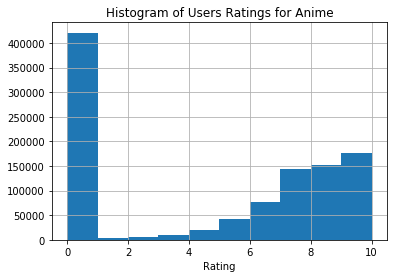

In [6]:
# Majority of scores are 0. The ratings data is sparse as is expected.

ratings.my_score.hist()
plt.title("Histogram of Users Ratings for Anime")
plt.xlabel("Rating")

In [7]:
# User Completed is believed to be the number of animes the user has watched and rated
# Many users have not rated many anime

users.user_completed[users.user_completed < 15].value_counts().sort_index()

0     455
1     779
2     932
3     878
4     798
5     784
6     749
7     714
8     612
9     652
10    597
11    556
12    551
13    564
14    533
Name: user_completed, dtype: int64

In [8]:
# The ratings data has 3201 different users
# Meaning the above numbers definition of users_complete cannot be correct

ratings.username.nunique()

3201

In [9]:
# There are 6,668 different anime within the dataset

anime.anime_id.nunique()

6668

In [10]:
# Average anime rating is around 7
# The values seen in the histogram indicate no score so is not considered in the mean

np.mean(anime.score)

6.848998200359958

Text(0.5, 0, 'Year')

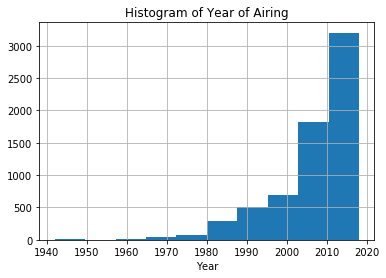

In [11]:
# Dataset contains mostly anime created past 2010

anime.aired_from_year.hist()
plt.title("Histogram of Year of Airing")
plt.xlabel("Year")

In [12]:
# Rename the column 'rating' in anime dataset to to 'age_rating'.
# Now this column won't get mixed up with user ratings

anime.rename(columns={'rating':'age_rating'}, inplace=True)

anime.columns

Index(['anime_id', 'title', 'title_english', 'episodes', 'age_rating', 'score',
       'scored_by', 'rank', 'popularity', 'members', 'genre', 'duration_min',
       'aired_from_year'],
      dtype='object')

In [13]:
# Most the anime in the list are PG-13, and a fair share of explicit content

anime.age_rating.value_counts()

PG-13 - Teens 13 or older         3396
G - All Ages                      1046
R - 17+ (violence & profanity)     758
R+ - Mild Nudity                   566
PG - Children                      488
Rx - Hentai                        332
None                                82
Name: age_rating, dtype: int64

# Data Preprocessing

### For Collaborative Model

In [14]:
# Joined anime and users data on users data so it now includes 

ratings = pd.merge(ratings, users, left_on ='username', right_on='username', how='left')

ratings.head()

,username,anime_id,my_score,user_id,user_completed,gender,birth_date,stats_mean_score
0,karthiga,21,9,2255153.0,49.0,Female,4/29/1990 0:00,7.43
1,karthiga,59,7,2255153.0,49.0,Female,4/29/1990 0:00,7.43
2,karthiga,74,7,2255153.0,49.0,Female,4/29/1990 0:00,7.43
3,karthiga,120,7,2255153.0,49.0,Female,4/29/1990 0:00,7.43
4,karthiga,178,7,2255153.0,49.0,Female,4/29/1990 0:00,7.43


In [15]:
ratings = pd.merge(ratings, anime[['anime_id','title']], left_on ='anime_id', right_on ='anime_id', how='left')

ratings.head()

,username,anime_id,my_score,user_id,user_completed,gender,birth_date,stats_mean_score,title
0,karthiga,21,9,2255153.0,49.0,Female,4/29/1990 0:00,7.43,One Piece
1,karthiga,59,7,2255153.0,49.0,Female,4/29/1990 0:00,7.43,Chobits
2,karthiga,74,7,2255153.0,49.0,Female,4/29/1990 0:00,7.43,Gakuen Alice
3,karthiga,120,7,2255153.0,49.0,Female,4/29/1990 0:00,7.43,Fruits Basket
4,karthiga,178,7,2255153.0,49.0,Female,4/29/1990 0:00,7.43,Ultra Maniac


In [16]:
# We see there are some anime id's where there is no title, since the title is important, 
# we will remove shows where there the title is missing

ratings.tail()

,username,anime_id,my_score,user_id,user_completed,gender,birth_date,stats_mean_score,title
1266460,GreenAngel333,21679,0,NaN,NaN,NaN,NaN,NaN,NaN
1266461,GreenAngel333,21681,0,NaN,NaN,NaN,NaN,NaN,Hanayamata
1266462,GreenAngel333,21737,0,NaN,NaN,NaN,NaN,NaN,Tamayura: More Aggressive - Tsuitachi dake no ...
1266463,GreenAngel333,21743,0,NaN,NaN,NaN,NaN,NaN,Donten ni Warau
1266464,GreenAngel333,21773,7,NaN,NaN,NaN,NaN,NaN,NaN


### For knowledge-based Recommendor

In [17]:
#Convert all NaN into stringified empty lists
anime['genres'] = anime['genre'].fillna('[]')

In [18]:
#Convert the genres from a string, to a list seperated by a comma
anime['genres'] = anime.genres.apply(lambda x: x.split(','))

# Drop the old genre column
anime = anime.drop('genre',axis=1)

anime.tail()

,anime_id,title,title_english,episodes,age_rating,score,scored_by,rank,popularity,members,duration_min,aired_from_year,genres
6663,37886,Wo Shi Jiang Xiaobai (2018),I&#039;m Joybo OVA,1,PG-13 - Teens 13 or older,0.00,0,12719.0,10168,384,0.0,2018,"[Slice of Life, Drama, Romance]"
6664,37888,Tian Yu,Revelation,13,PG-13 - Teens 13 or older,6.00,4,12485.0,14211,41,13.0,2017,"[Action, Adventure, Demons, Fantasy, Magic]"
6665,37894,Ling Yu 4th Season,NaN,12,PG-13 - Teens 13 or older,7.53,17,11126.0,12779,126,13.0,2016,[Fantasy]
6666,37895,Ling Yu 5th Season,NaN,12,PG-13 - Teens 13 or older,7.50,10,11127.0,13848,71,13.0,2017,[Fantasy]
6667,37896,Ling Yu 6th Season,NaN,0,PG-13 - Teens 13 or older,7.80,5,11128.0,13725,71,12.0,2018,[Fantasy]


In [19]:
animecopy = anime.copy().set_index('title')

#Explodes genre column so theres a repeating row for every different genre a show has
genre_exp = animecopy.explode('genres').sort_values(by='anime_id').reset_index()

#Keep only columns of interest
genre_exp = genre_exp[['title', 'age_rating', 'score', 'scored_by', 'aired_from_year', 'genres']]

#Removes whitespace from dataset. Duplicate genres were found due to whitespace
genre_exp = genre_exp.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [20]:
genre_exp.head(12)

,title,age_rating,score,scored_by,aired_from_year,genres
0,Cowboy Bebop,R - 17+ (violence & profanity),8.81,365465,1998,Space
1,Cowboy Bebop,R - 17+ (violence & profanity),8.81,365465,1998,Sci-Fi
2,Cowboy Bebop,R - 17+ (violence & profanity),8.81,365465,1998,Drama
3,Cowboy Bebop,R - 17+ (violence & profanity),8.81,365465,1998,Comedy
4,Cowboy Bebop,R - 17+ (violence & profanity),8.81,365465,1998,Adventure
5,Cowboy Bebop,R - 17+ (violence & profanity),8.81,365465,1998,Action
6,Cowboy Bebop: Tengoku no Tobira,R - 17+ (violence & profanity),8.41,111344,2001,Action
7,Cowboy Bebop: Tengoku no Tobira,R - 17+ (violence & profanity),8.41,111344,2001,Sci-Fi
8,Cowboy Bebop: Tengoku no Tobira,R - 17+ (violence & profanity),8.41,111344,2001,Mystery
9,Cowboy Bebop: Tengoku no Tobira,R - 17+ (violence & profanity),8.41,111344,2001,Space


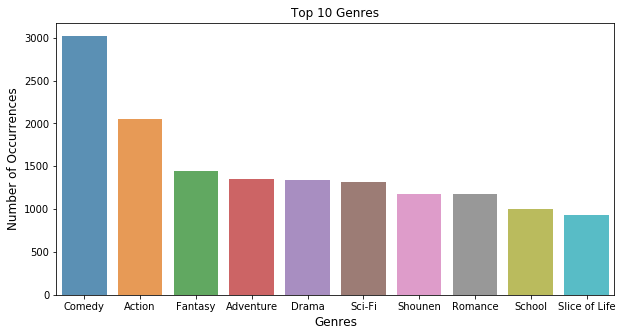

In [21]:
genre_count = genre_exp.genres.value_counts()
genre_count = genre_count[:10,]
plt.figure(figsize=(10,5))
sns.barplot(genre_count.index, genre_count.values, alpha =.8)
plt.title('Top 10 Genres')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Genres', fontsize=12)
plt.show()

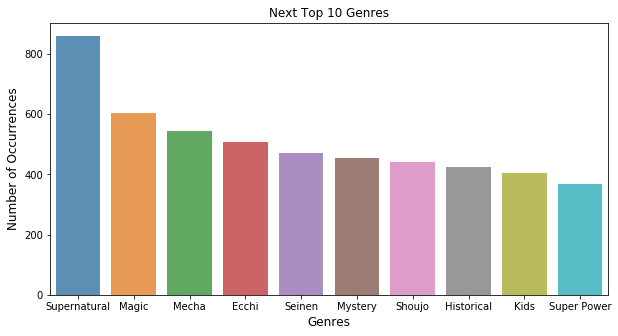

In [27]:
genre_count = genre_exp.genres.value_counts()
genre_count = genre_count[10:20,]
plt.figure(figsize=(10,5))
sns.barplot(genre_count.index, genre_count.values, alpha =.8)
plt.title('Next Top 10 Genres')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Genres', fontsize=12)
plt.show()

# Models

## Knowledge-based Recommender

In [23]:
def build_chart(genre_exp, percentile=0.8):
    #Ask for preferred genres
    print("Input preferred genre")
    genre = input()
    
    #Ask for lower limit of timeline
    print("Input earliest year")
    low_year = int(input())
    
    #Ask for upper limit of timeline
    print("Input latest year")
    high_year = int(input())
    
    #Define a new movies variable to store the preferred movies. Copy the contents of gen_df to movies
    movies = genre_exp.copy()
    
    #Filter based on the condition
    movies = movies[(movies['genres'] == genre) & 
                    (movies['aired_from_year'] >= low_year) & 
                    (movies['aired_from_year'] <= high_year)]

        #Compute the values of C and m for the filtered movies
    C = movies['score'].mean()
    m = movies['scored_by'].quantile(percentile)
    
    #Only consider movies that have higher than m votes. Save this in a new dataframe q_movies
    q_movies = movies.copy().loc[movies['scored_by'] >= m]
    
    #Calculate score using the IMDB formula
    q_movies['recommended_score'] = q_movies.apply(lambda x: (x['scored_by']/(x['scored_by']+m) * x['score']) 
                                       + (m/(m+x['scored_by']) * C)
                                       ,axis=1)

    #Sort movies in descending order of their scores
    q_movies = q_movies.sort_values('recommended_score', ascending=False)
    
    return q_movies

#### Built a successful feature based reccomendation system based on genre and airtime of showing. Of the anime that meet the users inputed criteria, those anime that have the highest score based off the IMDB scoring formula, as well as meet an acceptable level of popularity, are rated highest for the user

In [25]:
build_chart(genre_exp, percentile=.9)

Input preferred genre
Slice of Life
Input earliest year
2016
Input latest year
2018


,title,age_rating,score,scored_by,aired_from_year,genres,recommended_score
20089,Mob Psycho 100,PG-13 - Teens 13 or older,8.51,272959,2016,Slice of Life,8.298634
21019,Violet Evergarden,PG-13 - Teens 13 or older,8.59,111769,2018,Slice of Life,8.134165
20901,Kobayashi-san Chi no Maid Dragon,PG-13 - Teens 13 or older,8.19,196412,2017,Slice of Life,7.965772
18631,ReLIFE,PG-13 - Teens 13 or older,8.14,218273,2016,Slice of Life,7.942586
22394,Mahoutsukai no Yome,PG-13 - Teens 13 or older,8.30,97654,2017,Slice of Life,7.883545
20948,Saiki Kusuo no Ψ-nan (TV),PG-13 - Teens 13 or older,8.56,59498,2016,Slice of Life,7.879359
19637,3-gatsu no Lion,PG-13 - Teens 13 or older,8.43,66567,2016,Slice of Life,7.843645
22841,Sora yori mo Tooi Basho,PG-13 - Teens 13 or older,8.65,41939,2018,Slice of Life,7.780791
20583,Mahoutsukai no Yome: Hoshi Matsu Hito,PG-13 - Teens 13 or older,8.26,61403,2016,Slice of Life,7.712163
22681,Youkoso Jitsuryoku Shijou Shugi no Kyoushitsu ...,PG-13 - Teens 13 or older,7.93,119405,2017,Slice of Life,7.664614


## Collaborative Based Model

### Build Baseline Model

The ratings DataFrame contains user ratings for movies that range from 1 to 5. Therefore, we can model this problem as an instance of supervised learning where we need to predict the rating, given a user and a movie. Although the ratings can take on only five discrete values, we will model this as a regression problem (Banik, 2018, pg 172.)

In [28]:
ratings.columns

Index(['username', 'anime_id', 'my_score', 'user_id', 'user_completed',
       'gender', 'birth_date', 'stats_mean_score', 'title'],
      dtype='object')

In [29]:
#removed unncessary columns and nan values

ratings2 = ratings.drop(['username', 'title', 'user_completed','gender', 'birth_date', 'stats_mean_score'], axis=1).dropna()

ratings2.head()

,anime_id,my_score,user_id
0,21,9,2255153.0
1,59,7,2255153.0
2,74,7,2255153.0
3,120,7,2255153.0
4,178,7,2255153.0


In [30]:
# We don't need the ratings of 0

ratings2.my_score[ratings2.my_score == 0].value_counts()

0    207841
Name: my_score, dtype: int64

In [31]:
# Reduce ratings dataset to anime and users who have undergone a given threshold of ratings

min_user_ratings = 5
min_anime_ratings = 50
filter_scores = 0

filter_anime = ratings2.anime_id.value_counts() > min_anime_ratings
filter_anime = filter_anime[filter_anime].index.tolist()

filter_users = ratings2.user_id.value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

#filter Based off of minimum requirements
ratingsf = ratings2[(ratings2['anime_id'].isin(filter_anime)) & (ratings2['user_id'].isin(filter_users))]
ratingsf = ratingsf[ratingsf.my_score > 0]

#Rearrange dataset for compatability with Suprise Scikit library

ratingsf = ratingsf[['user_id', 'anime_id', 'my_score']]

print('The original data frame shape:\t{}'.format(ratings2.shape))
print('The new data frame shape:\t{}'.format(ratingsf.shape)) 

The original data frame shape:	(705375, 3)
The new data frame shape:	(450525, 3)


In [32]:
#1472 Users remaining

ratingsf.user_id.value_counts()

2485327.0    1851
48442.0      1549
168171.0     1429
3718629.0    1409
464538.0     1409
             ... 
82186.0         1
505214.0        1
279076.0        1
4759836.0       1
188603.0        1
Name: user_id, Length: 1472, dtype: int64

In [33]:
#Import the train_test_split function
from sklearn.model_selection import train_test_split

#Assign X as the original ratings dataframe and y as the user_id column of ratings.
X = ratingsf.copy()
y = ratingsf['user_id']

#Split into training and test datasets, stratified along user_id
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

In [35]:
#Of the remaining anime, the average score is 7.34

np.mean(ratingsf.my_score)

7.339548304755563

In [36]:
#Define the baseline model to always return 7.34, the average score in the dataset
#The baseline model will offer understanding for how our model is doing compared to a random guess

def baseline(user_id, title):
    return 7.34

In [37]:
#Function to compute the MAE score obtained on the testing set by a model
def score(cf_model):
    
    #Construct a list of user-movie tuples from the testing dataset
    id_pairs = zip(X_test['user_id'], X_test['anime_id'])
    
    #Predict the rating for every user-anime tuple
    y_pred = np.array([cf_model(user, movie) for (user, movie) in id_pairs])
    
    #Extract the actual ratings given by the users in the test data
    y_true = np.array(X_test['my_score'])
    
    #Return the final RMSE score
    return mean_absolute_error(y_true, y_pred)

In [38]:
score(baseline)

1.3229224376731303

**The baseline model has a mean absolute error of 1.322, not bad just for guessing by the average!**

### Weighted Mean ( A memory-based model)

Memory-based models  only make use of similarity metrics to come up with their results. They learn any parameters from the data or assign classes/clusters to the data. In other words, they do not make use of machine learning algorithms (Banik, 2018, pg 184).



In the previous model, we assigned equal weights to all the users. However, it makes intuitive sense to give more preference to those users whose ratings are similar to the user in question than the other users whose ratings are not. Therefore, let's alter our previous model by introducing a weight coefficient. This coefficient will be one of the similarity metrics that we computed in the previous chapter. (Banik,2018, Pg 177). 

![weighted mean](https://66.media.tumblr.com/dea702c6b0ddbff866e654bbf40eed08/153ce55cd06e83b4-3b/s540x810/280c63e9095a213a89dea61b91cba61b70fbb127.png)


In [39]:
#Create a dummy ratings matrix with all null values imputed to 0
r_matrix = X_train.pivot_table(values='my_score', index='user_id', columns='anime_id')

In [40]:
#Create a dummy ratings matrix with all null values imputed to 0

r_matrix_dummy = r_matrix.copy().fillna(0)

In [41]:
#Compute the cosine similarity matrix using the dummy ratings matrix
cosine_sim = cosine_similarity(r_matrix_dummy, r_matrix_dummy)

In [42]:
#Convert into pandas dataframe 
cosine_sim = pd.DataFrame(cosine_sim, index=r_matrix.index, columns=r_matrix.index)

cosine_sim.head(10)

user_id,1.0,687.0,877.0,935.0,1056.0,2380.0,3175.0,3512.0,3608.0,3748.0,...,6894967.0,6923415.0,6939613.0,6943016.0,6945221.0,6951406.0,7056886.0,7088516.0,7175534.0,7207226.0
user_id,,,,,,,,,,,,,,,,,,,,,
1.0,1.000000,0.366127,0.320565,0.245503,0.188654,0.208228,0.111930,0.332659,0.259956,0.138062,...,0.092300,0.161715,0.132381,0.178563,0.102824,0.025788,0.063483,0.056628,0.150878,0.141539
687.0,0.366127,1.000000,0.224267,0.214169,0.091554,0.076686,0.094909,0.257814,0.179817,0.089468,...,0.022166,0.125331,0.070734,0.141535,0.024944,0.025621,0.022725,0.055112,0.130408,0.112391
877.0,0.320565,0.224267,1.000000,0.229252,0.070042,0.086354,0.079423,0.231750,0.192397,0.117008,...,0.100735,0.165109,0.037784,0.163990,0.040575,0.049964,0.031190,0.053305,0.144792,0.112423
935.0,0.245503,0.214169,0.229252,1.000000,0.088835,0.051711,0.082121,0.218601,0.110802,0.118172,...,0.083741,0.144968,0.029257,0.144863,0.051429,0.017341,0.107105,0.000000,0.144911,0.134364
1056.0,0.188654,0.091554,0.070042,0.088835,1.000000,0.207705,0.000000,0.111475,0.173998,0.076535,...,0.050339,0.115747,0.113565,0.119752,0.175357,0.028260,0.019191,0.073548,0.099861,0.225734
2380.0,0.208228,0.076686,0.086354,0.051711,0.207705,1.000000,0.000000,0.176503,0.148955,0.082868,...,0.090126,0.166680,0.145000,0.162989,0.196317,0.134020,0.047544,0.091788,0.150058,0.073683
3175.0,0.111930,0.094909,0.079423,0.082121,0.000000,0.000000,1.000000,0.035480,0.105981,0.012896,...,0.000000,0.000000,0.000000,0.022317,0.000000,0.000000,0.000000,0.000000,0.023281,0.000000
3512.0,0.332659,0.257814,0.231750,0.218601,0.111475,0.176503,0.035480,1.000000,0.295587,0.183174,...,0.094611,0.225005,0.090379,0.235883,0.106062,0.110469,0.087995,0.030307,0.213505,0.148533
3608.0,0.259956,0.179817,0.192397,0.110802,0.173998,0.148955,0.105981,0.295587,1.000000,0.128372,...,0.074541,0.161665,0.053020,0.184438,0.028576,0.070235,0.055486,0.000000,0.163092,0.095065


In [43]:
#User Based Collaborative Filter using Weighted Mean Ratings
def cf_user_wmean(user_id, anime_id):
    
    #Check if movie_id exists in r_matrix
    if anime_id in r_matrix:
        
        #Get the similarity scores for the user in question with every other user
        sim_scores = cosine_sim[user_id]
        
        #Get the user ratings for the movie in question
        m_ratings = r_matrix[anime_id]
        
        #Extract the indices containing NaN in the m_ratings series
        idx = m_ratings[m_ratings.isnull()].index
        
        #Drop the NaN values from the m_ratings Series
        m_ratings = m_ratings.dropna()
        
        #Drop the corresponding cosine scores from the sim_scores series
        sim_scores = sim_scores.drop(idx)
        
        #Compute the final weighted mean
        wmean_rating = np.dot(sim_scores, m_ratings)/ sim_scores.sum()
    
    else:
        #Default to a rating of 3.0 in the absence of any information
        wmean_rating = 3.0
    
    return wmean_rating


In [44]:
score(cf_user_wmean)

0.9037138551204565

**The mean absolute error when using a weighted mean is .9. That's a fair imrpovement over guessing based on the mean**

### Model-based approaches (Supervised & Unsupervised models)

In [52]:
#Import the required classes and methods from the surprise library, a recommendor system scikit library
from surprise import Reader, Dataset, KNNBasic, SVD, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
from surprise.model_selection import cross_validate

In [50]:
#Define a Reader object
#The Reader object helps in parsing the file or dataframe containing ratings
reader = Reader(rating_scale=(1,9))

#Create the dataset to be used for building the filter
data = Dataset.load_from_df(ratingsf, reader)

In [62]:
benchmark = []
# Iterate over all algorithms
# Code obtained from https://towardsdatascience.com/svd-where-model-tuning-goes-wrong-61c269402919
for algorithm in [SVD(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['mae'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_mae')  

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_mae,fit_time,test_time
Algorithm,,,
KNNBaseline,0.720888,3.315402,31.525540
KNNWithZScore,0.727236,2.575105,27.871498
KNNWithMeans,0.732566,2.423521,27.017457
SVD,0.735351,13.185422,0.859369
SlopeOne,0.762303,8.490965,54.165693
KNNBasic,0.763070,2.431443,25.780503
CoClustering,0.815743,5.532568,0.869003
BaselineOnly,0.864319,0.846080,0.822809
NMF,1.704660,14.038932,0.811145


In [67]:
from surprise.model_selection import GridSearchCV
from surprise.prediction_algorithms import SVD

param_grid = {'n_factors': [50,100,150],'n_epochs': [20,30], 'lr_all': [0.005,0.01],'reg_all':[0.02,0.1]}
gs = GridSearchCV(SVD, param_grid, measures=['mae'], cv=3)
gs.fit(data)

In [71]:
params = gs.best_params['mae']
params

{'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}

In [74]:
svdtuned = SVD(n_factors=params['n_factors'], n_epochs=params['n_epochs'],lr_all=params['lr_all'], reg_all=params['reg_all'])

benchmark = []
# Iterate over all algorithms
for algorithm in [svdtuned]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['mae'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_mae')  

,test_mae,fit_time,test_time
Algorithm,,,
SVD,0.7275,8.426459,0.891958


### Results

Various types of algorithims were tried in to make predictions on the test data: Baseline algorithims, K-Nearest Neighbors, Matrix factorization-based, and clustering. Looking at the results, we see that KNNBaseline acheived the lowest mae, but at the cost of greater computation power. **Singular-value decomposition (SVD)**, without model-tuning, manged to acheive very close results to KNNBaseline, but in a fraction of the time. This is because unlike the other algorithims, SVD employs a dimensionality reduction technique that is not so different from principal component analysis. It takes in the typical sparse data matrix found in recommendor data, and transforms it in two two dense matrices, giving us the values from the oringal sparse data (Banik, 2018, pg 192).

Simon Funk, the winner of the Netflix data competition is the data scientist who enhances SVD to be able to take on sparse data in this way. From these results, I too would choose SVD as the algorithim to put into production

**Reference**

Banik, R. (2018). Hands-On Recommendation Systems With Python: start building powerful and personalized, ... recommendation engines with python.